使用torchvision.datasets.CelebA语句下载下来的原数据集包含了20多万张图，每张图的形状为218$*$178$*$3（即116412个输入节点）。要是完全使用原数据集，计算强度会非常大，训练神经网络的可行性会很低。因此要手动缩减数据集来适应不同的运算环境。

### 步骤1 安装并引入必要的库

In [ ]:
!pip install torch==1.4.0 torchvision==0.5.0
!pip install pandas==0.25.0
!pip install numpy==1.16.0
!pip install matplotlib==3.1.0

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

### 步骤2 导入并处理图像数据

In [7]:
#定义图像数据类，读取h5py格式图像
class CelebADataset(Dataset):
    #读取文件
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    #数据集大小
    def __len__(self):
        return len(self.dataset)
    #转化成.jpg图像
    def __getitem__(self, index):
        if (index >= len(self.dataset)): 
            raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.FloatTensor(img) / 255.0
    #显示图像
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    pass


本实验在cpu上运行，为保证运行顺利，我们已缩减原数据集（约20万张图）至500张图。

In [8]:
#导入数据集
celeba_dataset = CelebADataset('celeba_aligned_s500.h5py')

In [9]:
#显示图像，可在括号里填入1-500的任意数字（因为数据集包含了500幅人像图）
celeba_dataset.plot_image(490)

### 步骤3 定义辅助函数

In [10]:
#定义函数生成随机图像
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data
#定义函数生成随机数
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [11]:
#定义类，将原大小为（218，178，3）的三维图像张量转化成一个长度为218*178*3的一维张量
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

### 步骤4 定义判别器类

In [12]:
class Discriminator(nn.Module):

    def __init__(self):
        #初始化网络
        super().__init__()
        #定义神经网络层
        self.model = nn.Sequential(
            View(218*178*3),

            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),

            nn.LayerNorm(100),

            nn.Linear(100, 1),
            nn.Sigmoid()
        )       
        #创建损失函数
        self.loss_function = nn.BCELoss()
        #创建优化器
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        #计数器
        self.counter = 0;
        #进程记录
        self.progress = []
        pass

    def forward(self, inputs):
        #直接运行模型
        return self.model(inputs)

    def train(self, inputs, targets):
        #计算网络的输出
        outputs = self.forward(inputs)
        #计算损失值
        loss = self.loss_function(outputs, targets)
        #每训练10次计数器加一 ，计数器每增加50次时显示一下
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 50 == 0):
            print("counter = ", self.counter)
            pass
        #梯度归零，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass

    #建立函数，绘制损失值变化的图形
    def plot_progress(self):
        loss_list = self.progress
        plt.title('discriminator train loss', fontsize=10)
        plt.plot(loss_list)
        pass

    pass

构建完判别器后，我们要来对其进行测试。由于现在还未创建生成器，目前测试判别器的方法就是看它能否将真实数据与随机数据区分开来。

In [13]:
#简单训练判别器，运行时间大约在2分钟左右
D = Discriminator()

for image_data_tensor in celeba_dataset:
    #真实数据
    D.train(image_data_tensor, torch.FloatTensor([1.0]))   
    #假数据
    D.train(generate_random_image((218,178,3)), torch.FloatTensor([0.0]))  
    pass

counter =  50
counter =  100
counter =  150
counter =  200
counter =  250
counter =  300
counter =  350
counter =  400
counter =  450
counter =  500
counter =  550
counter =  600
counter =  650
counter =  700
counter =  750
counter =  800
counter =  850
counter =  900
counter =  950
counter =  1000


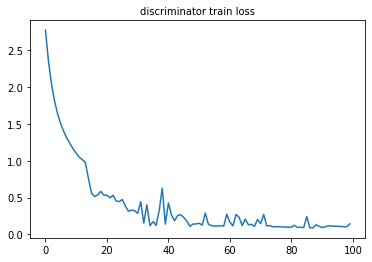

In [15]:
#绘制训练过程的损失曲线图
%matplotlib inline
D.plot_progress()

从上图中我们可以发现，判别器的损失曲线先是从3.0左右的损失值快速下降，经过一些波动，慢慢平稳在0.25左右，可见训练的过程中判别器的判别能力得到提升。接下来，我们来测试一下判别器是否能判别人脸/非人脸的图像。

In [16]:
#从数据集里随机选取4张图作为真实数据
print('对人脸图像的判别结果（应判为1）')
for i in range(4):
    image_data_tensor = celeba_dataset[random.randint(0,500)]
    print( D.forward( image_data_tensor ).item() )
    pass
#用辅助函数生成4张假图像
print('对非人脸图像的判别结果（应判为0）')
for i in range(4):
    print( D.forward( generate_random_image((218,178,3))).item() )
    pass

对人脸图像的判别结果（应判为1）
0.9856516122817993
0.9834340810775757
0.9762384295463562
0.9782950282096863
对非人脸图像的判别结果（应判为0）
0.12497077137231827
0.12149868905544281
0.1124696135520935
0.11195989698171616


从以上数据我们可以看出判别器对人脸图像的判别结果（前四行数据）均在0.9多，近似于1；对非人脸图像的判别结果（后四行数据）均在0.1左右，近似于0。这样的结果表明简单训练后的判别器已经具有较好的分辨人脸/非人脸的能力了。

### 步骤5 定义生成器类

In [17]:
class Generator(nn.Module):

    def __init__(self):
        #初始化网络
        super().__init__()
        #定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),

            nn.LayerNorm(3*10*10),

            nn.Linear(3*10*10, 3*218*178),

            nn.Sigmoid(),
            View((218,178,3))
        )
        #创建优化器
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        #计数器
        self.counter = 0;
        #进程记录
        self.progress = []
        pass

    def forward(self, inputs):        
        #直接运行模型
        return self.model(inputs)

    def train(self, D, inputs, targets):
        #计算网络的输出
        g_output = self.forward(inputs)
        #传入鉴别器
        d_output = D.forward(g_output)
        #计算损失值
        loss = D.loss_function(d_output, targets)
        #每十次训练计数器加一 
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        #梯度归零，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass

    #定义函数，绘制损失图像
    def plot_progress(self):
        loss_list = self.progress
        plt.title('generator train loss', fontsize=10)
        plt.plot(loss_list)
        pass

    pass  

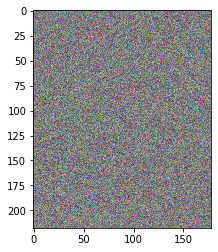

In [18]:
#创建一个生成器对象
G = Generator()
#用生成器网络生成假图像
output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
#显示生成器的初始生成能力
plt.imshow(img, interpolation='none', cmap='Blues')

### 步骤6 训练生成器与判别器

In [19]:
#创建判别器和生成器
D = Discriminator()
G = Generator()
#训练过程大概为8分钟，请耐心等待:)
epochs = 1
for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    for image_data_tensor in celeba_dataset:
        #用真实样本训练判别器
        D.train(image_data_tensor, torch.FloatTensor([1.0]))
        #用生成样本训练判别器
        #使用detach()以避免计算生成器G中的梯度
        D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
        #训练生成器
        G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))
        pass
    pass

epoch =  1
counter =  50
counter =  100
counter =  150
counter =  200
counter =  250
counter =  300
counter =  350
counter =  400
counter =  450
counter =  500
counter =  550
counter =  600
counter =  650
counter =  700
counter =  750
counter =  800
counter =  850
counter =  900
counter =  950
counter =  1000


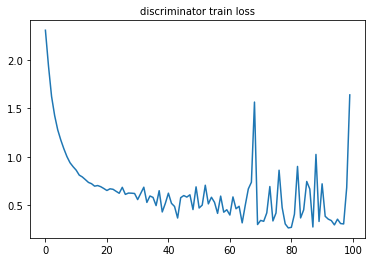

In [20]:
#绘制判别器训练过程的损失曲线图
D.plot_progress()

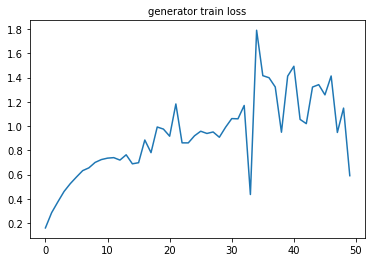

In [21]:
#绘制生成器训练过程的损失曲线图
G.plot_progress()

### 步骤7 生成人脸图像

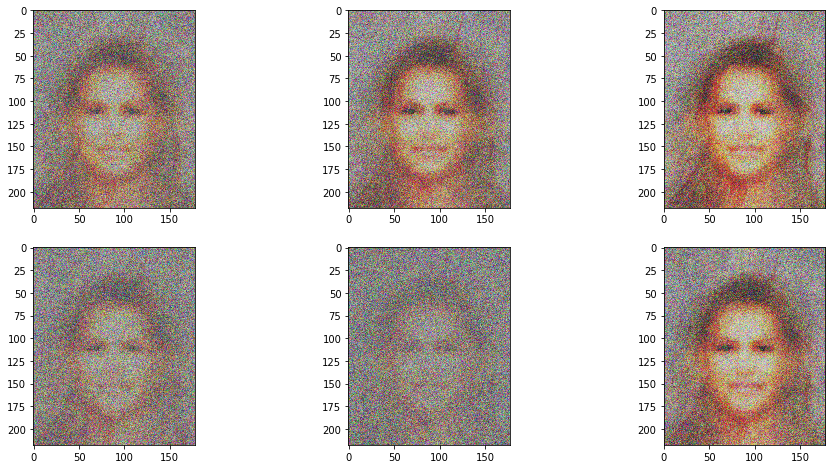

In [22]:
#将生成的图像绘制出来，并以三行两列的方式呈现
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass